In [1]:
import os
os.chdir("/home/haok/MoE-Research")

from pathlib import Path
from typing import Tuple, List, Optional

import torch
import seaborn as sns
import matplotlib.pyplot as plt
from torch import Tensor
from matplotlib.ticker import FuncFormatter

from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pythia-12b")


In [2]:
def load(
    checkpoint_step: int,
    layer_number: int = 18,
    expert_index: int = 24,
    min_samples: int = 100,
    top_k: int = 5,
    indices: Optional[List[int]] = None,
) -> Tuple[Tensor, Tensor]:

    # Load the data in a safe fashion
    data = torch.load(
        f"/project/flame/haok/results/expert-specialization/flame-moe-1.7b/"
        f"{checkpoint_step}/{layer_number}-{expert_index}.pt"
    )
    assert isinstance(data, tuple) and len(data) == 2
    assert isinstance(data[0], Tensor) and isinstance(data[1], Tensor)

    # Fraction of times this expert activates a given token
    sample_count, active_count = data
    specialization = torch.where(
        sample_count > 0,
        active_count.float() / sample_count.float(),
        torch.zeros_like(sample_count, dtype=torch.float)
    )

    # If desired, load those particular tokens
    if indices is not None:
        return specialization[[indices]], torch.Tensor(indices)

    # Mask out low-sample entries
    specialization = torch.where(
        sample_count >= min_samples,
        specialization,
        torch.tensor(float('-inf'))
    )

    # Select the top-k most specialized tokens
    pack = specialization.topk(k=top_k)
    return pack.values, pack.indices


In [3]:
expert_indices = torch.tensor([0, 1, 6, 9])

layer_number, min_samples, top_k = 18, 5, 2
last_indices = torch.zeros(expert_indices.max() + 1, top_k, dtype=torch.int64)

for expert_index in expert_indices:
    values, indices = load(
        checkpoint_step=11029,
        layer_number=layer_number, expert_index=expert_index,
        min_samples=min_samples, top_k=top_k
    )
    last_indices[expert_index] = indices

lines: List[Tuple[int, List[Tuple[int, List[float]]]]] = []
for expert_index in expert_indices:
    line = []
    for checkpoint_step in [1100, 2200, 4400, 5500, 6600, 7700, 8800, 9900, 11029]:
        values, indices = load(
            checkpoint_step=checkpoint_step,
            layer_number=layer_number, expert_index=expert_index,
            indices=last_indices[expert_index],
        )
        line.append((checkpoint_step, values.tolist()))
        print(
            f"checkpoint={checkpoint_step} layer={layer_number} expert={expert_index} |".rjust(36), 
            values, indices, [tokenizer.decode(tid) for tid in indices],
        )
    lines.append((expert_index.item(), line))
    print("=" * 36)


 checkpoint=1100 layer=18 expert=0 | tensor([0.2000, 0.2500]) tensor([44394, 36474]) ['TextBox', ' univariate']
 checkpoint=2200 layer=18 expert=0 | tensor([0.2000, 0.2500]) tensor([44394, 36474]) ['TextBox', ' univariate']
 checkpoint=4400 layer=18 expert=0 | tensor([0.2000, 0.3750]) tensor([44394, 36474]) ['TextBox', ' univariate']
 checkpoint=5500 layer=18 expert=0 | tensor([0.8000, 0.5000]) tensor([44394, 36474]) ['TextBox', ' univariate']
 checkpoint=6600 layer=18 expert=0 | tensor([0.4000, 0.5000]) tensor([44394, 36474]) ['TextBox', ' univariate']
 checkpoint=7700 layer=18 expert=0 | tensor([0.6000, 0.3750]) tensor([44394, 36474]) ['TextBox', ' univariate']
 checkpoint=8800 layer=18 expert=0 | tensor([0.8000, 0.6250]) tensor([44394, 36474]) ['TextBox', ' univariate']
 checkpoint=9900 layer=18 expert=0 | tensor([0.6000, 0.6250]) tensor([44394, 36474]) ['TextBox', ' univariate']
checkpoint=11029 layer=18 expert=0 | tensor([0.8000, 0.6250]) tensor([44394, 36474]) ['TextBox', ' univa

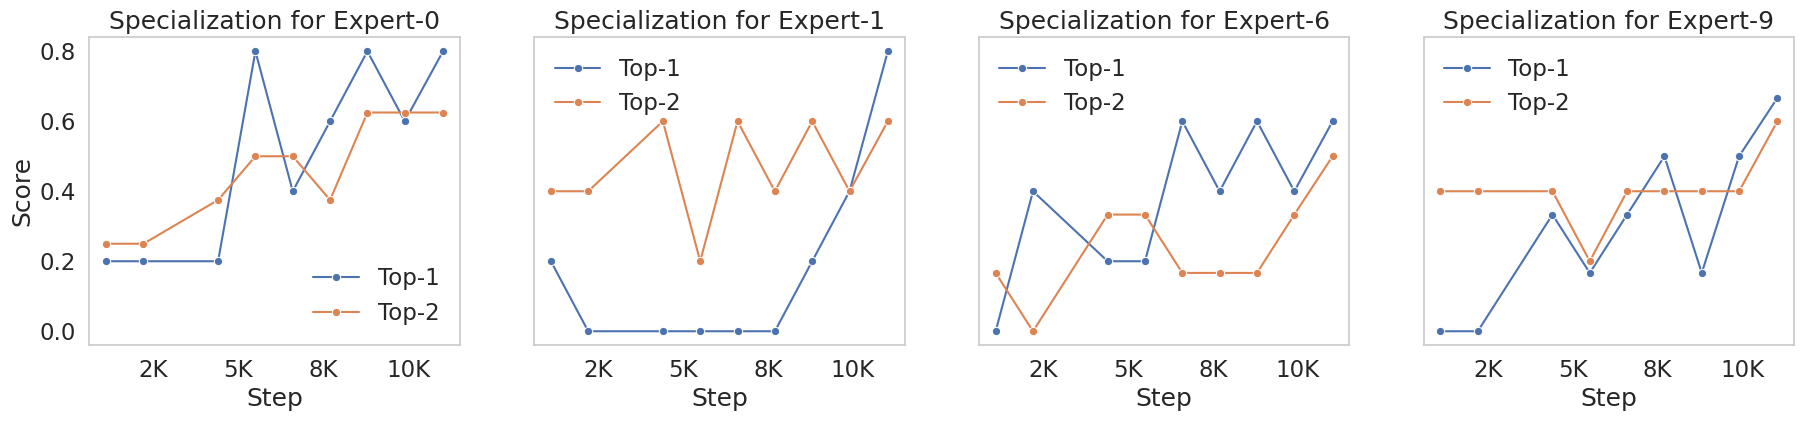

In [ ]:
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Times New Roman'

def human_format(x, pos):
    if x >= 1e9:
        return f'{x/1e9:.0f}B'
    elif x >= 1e6:
        return f'{x/1e6:.0f}M'
    elif x >= 1e3:
        return f'{x/1e3:.0f}K'
    else:
        return f'{x}'

sns.set_theme(style="whitegrid", font_scale=1.5)
fig, axes = plt.subplots(1, len(lines), figsize=(5 * len(lines) + 2, 4), sharey=True)

for ax, (expert_id, series) in zip(axes, lines):
    steps = [step for step, _ in series]
    value_lists = list(zip(*[vals for _, vals in series]))

    for j, scores in enumerate(value_lists):
        sns.lineplot(x=steps, y=scores, marker='o', ax=ax, label=f"Top-{j+1}")

    ax.grid(False)
    ax.set_title(f"Specialization for Expert-{expert_id}")
    ax.set_ylabel("Score" if ax is axes[0] else "")
    ax.set_xlabel("Step")
    ax.xaxis.set_major_formatter(FuncFormatter(human_format))
    ax.legend(frameon=False)

joined_ids = "-".join(str(expert_id) for expert_id, _ in lines)
file = Path(f"figures/expert-specialization/flame-moe-1.7b/{layer_number}/{joined_ids}.pdf")
file.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(file, bbox_inches='tight', pad_inches=0)
plt.show()
